# Network Distance with LION map (weight)
We will attempt to use networkx library with the lion map to calculate network distance for people walking between two points.
What I learned:
- weights need to be specified in order to calculate the right shortest_path
- edges between nodes do not have have physical distance unless you specify the attribute in the edges

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import box, LineString, Point,MultiPoint
import os
import sys
import fiona
import numpy as np

sys.path.append(os.path.realpath('..'))

In [2]:
print(fiona.__version__)

1.8.4


In [3]:
print(nx.__version__)

2.3


## Load Lion

In [4]:
shp_file = r"../intermediate_data/lion_gdf2012/lion_gdf2012.shp"
lion_shp = gpd.read_file(shp_file)
lion_shp.crs = {'init': 'epsg:4326'}

A more robust way to map node integers and position as suggested by
https://github.com/networkx/networkx/issues/3533#issuecomment-519739349

In [6]:
lion_graph = nx.read_shp(shp_file, simplify=False)
G = lion_graph.to_undirected()
G = nx.convert_node_labels_to_integers(G, first_label = 0, label_attribute='pos')
pos = nx.get_node_attributes(G, 'pos')

Create a nodes geopandas dataframe so that we can extract the geometries later

In [7]:
node_df = pd.DataFrame(pos.items(), columns=['node_id', 'geometry'])
node_df['geometry'] = node_df['geometry'].apply(Point)
node_gdf = gpd.GeoDataFrame(node_df, geometry='geometry')
node_gdf.crs = {'init': 'epsg:4326'}

Examine the attributes of the edges. Locate the variable that gives the distance of the edge

In [ ]:
#list(G.edges(data=True))[0]

## Network analysis!

In [48]:
orig_node = 36640
target_node = 34029

Make a geodataframe to store the data

In [51]:
route_geom = gpd.GeoDataFrame(crs=node_gdf.crs)
route_geom['geometry'] = None
route_geom['id'] = None

In [49]:
# Without weight
route = nx.shortest_path(G=G, source=orig_node, target=target_node, weight = None)
route_nodes = node_gdf.loc[route]
route_line = LineString(list(route_nodes.geometry.values))
route_geom.loc[0, 'geometry'] = route_line
route_geom.loc[0, 'id'] = str(list(route_nodes['node_id'].values))

In [53]:
# Using SHAPE_Leng as the weight
route = nx.shortest_path(G=G, source=orig_node, target=target_node, weight = 'SHAPE_Leng')
route_nodes = node_gdf.loc[route]
route_line = LineString(list(route_nodes.geometry.values))
route_geom.loc[1, 'geometry'] = route_line
route_geom.loc[1, 'id'] = str(list(route_nodes['node_id'].values))

In [59]:
# Using a different distance attribute
route = nx.shortest_path(G=G, source=orig_node, target=target_node, weight = 'distance')
route_nodes = node_gdf.loc[route]
route_line = LineString(list(route_nodes.geometry.values))
route_geom.loc[2, 'geometry'] = route_line
route_geom.loc[2, 'id'] = str(list(route_nodes['node_id'].values))

In [61]:
# Using dijkstra_path
route = nx.dijkstra_path(G, source=orig_node, target=target_node, weight = 'distance')
route_nodes = node_gdf.loc[route]
route_line = LineString(list(route_nodes.geometry.values))
route_geom.loc[3, 'geometry'] = route_line
route_geom.loc[3, 'id'] = str(list(route_nodes['node_id'].values))

In [65]:
# Using bellman_ford_path
route = nx.bellman_ford_path(G, source=orig_node, target=target_node, weight = 'distance')
route_nodes = node_gdf.loc[route]
route_line = LineString(list(route_nodes.geometry.values))
route_geom.loc[4, 'geometry'] = route_line
route_geom.loc[4, 'id'] = str(list(route_nodes['node_id'].values))

In [89]:
# Manually creating the route
route = [36640, 44476, 48098, 41035, 41036, 44649, 57390, 57389, 57388, 57387, 57386, 57385, 57384, 57383, 57382, 57381, 57380, 57379, 57378, 57363, 57377, 57376, 57375, 57374, 57373, 57372, 57371, 57370, 57369, 57368, 57367, 57366, 57365, 42142, 34054, 30920, 36755, 36754, 36753, 36752, 36751, 36750, 36749, 36748, 36747, 36746, 36745, 36744, 34030, 34029]
route_nodes = node_gdf.loc[route]
route_line = LineString(list(route_nodes.geometry.values))
route_geom.loc[5, 'geometry'] = route_line
route_geom.loc[5, 'id'] = str(list(route_nodes['node_id'].values))

In [93]:
route_geom['distance'] = route_geom['geometry'].length

In [94]:
route_geom.head(6)

,geometry,id,distance
0,LINESTRING (-73.87934833267502 40.655788576932...,"[36640, 44476, 48098, 41035, 41036, 44649, 573...",0.010279
1,LINESTRING (-73.87934833267502 40.655788576932...,"[36640, 44476, 48098, 41035, 57356, 57357, 573...",0.010277
2,LINESTRING (-73.87934833267502 40.655788576932...,"[36640, 44476, 48098, 41035, 57356, 57357, 573...",0.010277
3,LINESTRING (-73.87934833267502 40.655788576932...,"[36640, 44476, 48098, 41035, 57356, 57357, 573...",0.010277
4,LINESTRING (-73.87934833267502 40.655788576932...,"[36640, 44476, 48098, 41035, 57356, 57357, 573...",0.010277
5,LINESTRING (-73.87934833267502 40.655788576932...,"[36640, 44476, 48098, 41035, 41036, 44649, 573...",0.005815


You can see that the manually created route is shorter.

## Printing the route/edge using the bbox of the route_geom

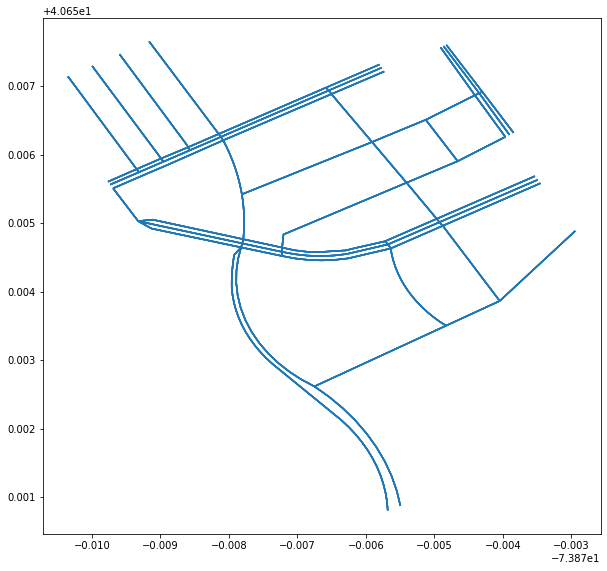

In [77]:
bounding_box = route_geom.envelope
df = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])
df['bbox'] = 1
df.crs = {'init': 'epsg:4326'}
join_left_df = gpd.sjoin(lion_shp, df, how="left")
join_left_df = gpd.GeoDataFrame(join_left_df.loc[join_left_df['bbox'] == 1])
join_left_df.plot(figsize = (10,10))

## Overlaying the route on top of the edge lines

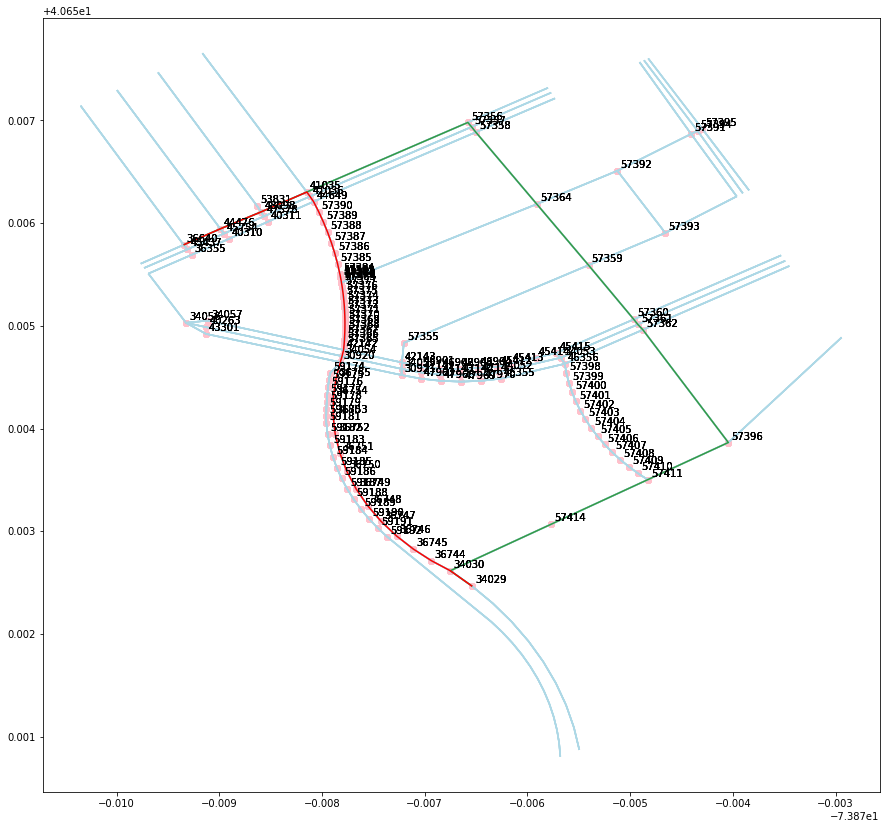

In [91]:
base = join_left_df.loc[join_left_df['bbox'] == 1].plot(figsize = (15,15), color = 'lightblue')

ax = node_join_left_df.loc[node_join_left_df['bbox'] == 1].plot(ax=base, figsize = (15,15), color = 'pink')

for x, y, label in zip(node_join_left_df.geometry.x, node_join_left_df.geometry.y, node_join_left_df.node_id):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

route_geom.loc[[1],'geometry'].plot(ax=base, color='green', alpha=0.7);
route_geom.loc[[5],'geometry'].plot(ax=base, color='red', );
